In [6]:
import pandas as pd
import numpy as np
from numpy.linalg import inv
import math
from matplotlib import pyplot as plt
from random import randrange
%matplotlib inline

#**MUST USE LOCAL COPY OF EXCEL DOC FOR THIS TO WORK, this is where acceleration observations pull from
dataSaveLocation = r'C:\Users\Ben\Desktop\School 2018-19\Rocket\SKYPILOT_BODY_IREC_2019.CSV.xlsx'

In [7]:
#Import experimental data taken, load data into DataFrame
experimentData = pd.read_excel(dataSaveLocation,dtype=str)
df = pd.DataFrame(experimentData, columns=['Time (ms)','Accelerometer - Acceleration X (g)','Our - Altitude (m)','Barometer - Pressure (mbar)'])

#Display numbers as floats
np.set_printoptions(suppress=True)

#Get acceleration observations data from excel doc
aObservations = df['Accelerometer - Acceleration X (g)'][54756:55800].values #This range is where ascent/apogee occur
aObservations = aObservations.astype(np.float) #Display numbers as floats
aObservations = (aObservations - 1)*9.81 #Convert from g to m/s^2

#Get altitude information from excel doc
measuredAltitude = df['Our - Altitude (m)'][54756:55800].values
measuredAltitude = measuredAltitude.astype(np.float)

#Get pressure information from excel doc
measuredPressure = df['Barometer - Pressure (mbar)'][54756:55800].values
measuredPressure = measuredPressure.astype(np.float)
calculatedAltitude = -8333.33*np.log(measuredPressure/1013.25) - 1393.335

In [8]:
#Initialize constants/initial values
N = len(aObservations)

# Initial Conditions
a = 0  # Acceleration
v = 0  # Velocity
x = 0  # Position
t = 0.05  # Difference in time
n = 3

#Initialize position and velocity arrays
xObservations = np.zeros(N)
vObservations = np.zeros(N)

#Set position/velocity initial conditions
xObservations[0] = x
vObservations[0] = v

#Define errors
# Process / Estimation Errors
error_est_x = 20
error_est_v = 5
error_est_a = 3

# Observation Errors
error_obs_x = 25  # Uncertainty in the measurement
error_obs_v = 6
error_obs_a = 4

In [9]:
#Add acceleration prediction
aPrediction = np.zeros(N)

#Create artificial acceleration curve
for i in range(1,40):
    aPrediction[i] = 3*i

for i in range(40,75):
    aPrediction[i] = 125

for i in range(75,133):
    aPrediction[i] = -3*i + 348

for i in range(133,260):
    aPrediction[i] = -80 + i/4
    
for i in range(260,N):
    aPrediction[i] = -12

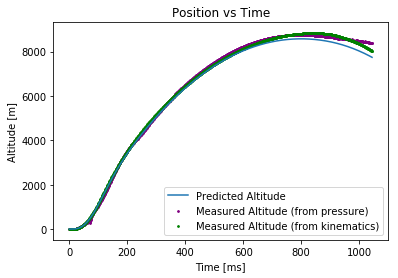

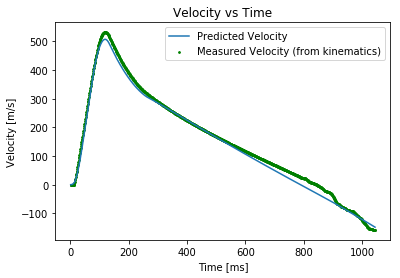

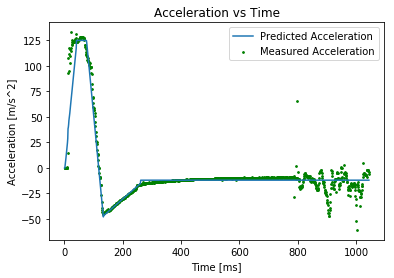

In [10]:
#Used for acceleration prediction indexing
accelIndex = 0

# Create position and velocity observations from acceleration observations using simple kinematics
for i in range(1,N):
    xObservations[i] = xObservations[i-1] + t*vObservations[i-1] + 0.5*aObservations[i-1]*(t**2)
    vObservations[i] = vObservations[i-1] + t*aObservations[i-1]
    
#Column stack all observations such that each column is all data points of either position, velocity, or acceleration
z = np.c_[xObservations, vObservations, aObservations]

#Predicts the position, velocity, and acceleration of the next time step
def prediction3d(position, velocity, time):
    global accelIndex
    acceleration = aPrediction[accelIndex]
    
    A = np.array([[1, time, 0.5*(time**2)],
                  [0, 1, time],
                  [0, 0, 1]])
    X = np.array([[position],
                  [velocity],
                  [acceleration]])

    accelIndex = accelIndex + 1
    return A.dot(X)

# Calculates the covariance of all variables with one another
def covariance3d(sigma1, sigma2, sigma3):
    cov1_2 = sigma1 * sigma2
    cov1_3 = sigma1 * sigma3
    cov2_1 = sigma2 * sigma1
    cov2_3 = sigma2 * sigma3
    cov3_1 = sigma3 * sigma1
    cov3_2 = sigma3 * sigma2
    cov_matrix = np.array([[sigma1 ** 2, cov1_2, cov1_3],
                           [cov2_1, sigma2 ** 2, cov2_3],
                           [cov3_1, cov3_2, sigma3 **2]])
    return np.diag(np.diag(cov_matrix))


# Initial Estimation Covariance Matrix
P = covariance3d(error_est_x, error_est_v, error_est_a)

# Initial Estimation Matrix
A = np.array([[1, t, 0.5*(t**2)],
              [0, 1, t],
              [0, 0, 1]])

# Initial State Matrix
X = np.array([[x],
              [v],
              [a]])

#Create matrix to store all state values
plotX = []
plotX.append(X) #Add initial state to state matrix

#Execute Kalman formula operations for each observed data point
for data in z[1:]:
    X = prediction3d(X[0][0], X[1][0], t)

    P = np.diag(np.diag(A.dot(P).dot(A.T)))

    # Calculating the Kalman Gain
    H = np.identity(n)
    R = covariance3d(error_obs_x, error_obs_v, error_obs_a)
    S = H.dot(P).dot(H.T) + R
    K = P.dot(H).dot(inv(S))

    # Reshape the new data into the measurement space.
    Y = H.dot(data).reshape(n, -1)

    # Update the State Matrix
    # Combination of the predicted state, measured values, covariance matrix and Kalman Gain
    X = X + K.dot(Y - H.dot(X))
    
    #Update state matrix
    plotX.append(X)

    # Update Process Covariance Matrix
    P = (np.identity(len(K)) - K.dot(H)).dot(P)

#Create time step array for plotting purposes
time = np.linspace(1,N,N)

#Extract position, velocity, acceleration from state matrix
position = [predict[0][0] for predict in plotX]
velocity = [predict[1][0] for predict in plotX]
acceleration = [predict[2][0] for predict in plotX]

#Plot position
plt.scatter(time,calculatedAltitude,s=3,c='Purple')
#plt.scatter(time,measuredAltitude,s=3,c='Red')
plt.scatter(time,xObservations,s=3,c='Green')
plt.plot(time,position)
plt.title("Position vs Time")
plt.xlabel("Time [ms]")
plt.ylabel("Altitude [m]")
plt.legend(["Predicted Altitude","Measured Altitude (from pressure)","Measured Altitude (from kinematics)"])
plt.show()

#Plot velocity
plt.scatter(time,vObservations,s=3,c='Green')
plt.plot(time,velocity)
plt.title("Velocity vs Time")
plt.xlabel("Time [ms]")
plt.ylabel("Velocity [m/s]")
plt.legend(["Predicted Velocity", "Measured Velocity (from kinematics)"])
plt.show()

#Plot acceleration
plt.scatter(time,aObservations,s=3,c='Green')
plt.plot(time,acceleration)
plt.title("Acceleration vs Time")
plt.xlabel("Time [ms]")
plt.ylabel("Acceleration [m/s^2]")
plt.legend(["Predicted Acceleration", "Measured Acceleration"])
plt.show()